# 1. Import Libraries

In [1]:
import tqdm
import cv2
import splitfolders
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=Warning)

from sklearn.metrics import confusion_matrix, classification_report
from IPython.display import HTML

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.applications import ResNet50

# 2. Split Data into Train/Val/Test Folders

In [2]:
splitfolders.ratio(
    "./data_by_class/", 
    output="./data_by_set/", 
    seed=21, 
    ratio=(0.9, 0.05, 0.05), 
    group_prefix=None
)

Copying files: 24955 files [04:13, 98.32 files/s] 


# 3. Prepare Image Augmentation

In [3]:
train_datagen = ImageDataGenerator(
    horizontal_flip=True,
    rotation_range=15,
    zoom_range=0.15,
    brightness_range=[0.85,1.15],
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

# 4. Prepare Train/Val/Test Data Set in Numpy 

In [4]:
%%time

train_dataset = train_datagen.flow_from_directory(
    directory='./data_by_set/train',
    target_size=(150, 150), 
    batch_size=128,
    shuffle=False,
    class_mode='binary',
    seed=21
)

valid_dataset = valid_datagen.flow_from_directory(
    directory='./data_by_set/val',
    target_size=(150, 150), 
    batch_size=32,
    shuffle=False,
    class_mode='binary',
    seed=21
)

test_dataset = test_datagen.flow_from_directory(
    directory='./data_by_set/test',
    target_size=(150, 150), 
    batch_size=32,
    shuffle=False,
    class_mode='binary',
    seed=21
)

X_train, y_train = next(train_dataset)
X_val, y_val = next(valid_dataset)
X_test, y_test = next(test_dataset)

for i in tqdm.tqdm(range(len(train_dataset)-1)): 
    img, label = next(train_dataset)
    X_train = np.append(X_train, img, axis=0)
    y_train = np.append(y_train, label, axis=0)
    
for i in tqdm.tqdm(range(len(valid_dataset)-1)): 
    img, label = next(valid_dataset)
    X_val = np.append(X_val, img, axis=0)
    y_val = np.append(y_val, label, axis=0)
    
for i in tqdm.tqdm(range(len(test_dataset)-1)): 
    img, label = next(test_dataset)
    X_test = np.append(X_test, img, axis=0)
    y_test = np.append(y_test, label, axis=0)

Found 22457 images belonging to 2 classes.
Found 1247 images belonging to 2 classes.
Found 1249 images belonging to 2 classes.


 95%|████████████████████████████████████████████████████████████████████████████▎   | 167/175 [10:42<00:56,  7.09s/it]C:\Users\tanpe\anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  warnings.warn(
C:\Users\tanpe\anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  warnings.warn(
C:\Users\tanpe\anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  warnings.warn(
C:\Users\tanpe\anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  warnings.warn(
C:\Users\tanpe\anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting t

Wall time: 12min 16s


# 5. Run ResNet Inference to Obtain Features

In [5]:
%%time

global_average_layer = GlobalAveragePooling2D()

pretrained_model = ResNet50(input_shape=(150,150,3),
                            include_top=False,
                            weights="imagenet")

z_train = preprocess_input(X_train)
z_train = pretrained_model.predict(z_train)
feature_batch = global_average_layer(z_train)
X_train_feature = np.array(feature_batch)

z_val = preprocess_input(X_val)
z_val = pretrained_model.predict(z_val)
feature_batch = global_average_layer(z_val)
X_val_feature = np.array(feature_batch)

z_test = preprocess_input(X_test)
z_test = pretrained_model.predict(z_test)
feature_batch = global_average_layer(z_test)
X_test_feature = np.array(feature_batch)

Wall time: 31min 17s


# 6. Initialize and Train Model

In [20]:
tf.random.set_seed(21)

model = tf.keras.models.Sequential([
    Dense(512,input_shape=(2048,),activation="swish"),
    Dropout(0.7),
    Dense(256,activation="swish"),
    Dropout(0.5),
    Dense(128,activation="swish"),
    Dropout(0.3), 
    Dense(32,activation="tanh"),
    Dropout(0.2), 
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=RMSprop(learning_rate=1e-4),
                             loss="binary_crossentropy",
                             metrics=['accuracy'])

callbacks=[EarlyStopping(patience=20, 
                         verbose=1, 
                         restore_best_weights=True,
                         monitor='val_accuracy')]

In [21]:
%%time

history = model.fit(
    X_train_feature,
    y_train,
    batch_size=256,
    validation_data=(X_val_feature,y_val),
    callbacks=callbacks,
    epochs=200,
)

Epoch 1/200
88/88 [==============================] - 4s 26ms/step - loss: 0.4967 - accuracy: 0.7476 - val_loss: 0.0866 - val_accuracy: 0.9687
Epoch 2/200
88/88 [==============================] - 3s 31ms/step - loss: 0.1577 - accuracy: 0.9469 - val_loss: 0.0800 - val_accuracy: 0.9735
Epoch 3/200
88/88 [==============================] - 3s 35ms/step - loss: 0.1207 - accuracy: 0.9588 - val_loss: 0.0820 - val_accuracy: 0.9727
Epoch 4/200
88/88 [==============================] - 3s 38ms/step - loss: 0.1060 - accuracy: 0.9630 - val_loss: 0.0765 - val_accuracy: 0.9751
Epoch 5/200
88/88 [==============================] - 3s 33ms/step - loss: 0.0916 - accuracy: 0.9707 - val_loss: 0.0691 - val_accuracy: 0.9783
Epoch 6/200
88/88 [==============================] - 3s 35ms/step - loss: 0.0857 - accuracy: 0.9706 - val_loss: 0.0682 - val_accuracy: 0.9800
Epoch 7/200
88/88 [==============================] - 3s 32ms/step - loss: 0.0846 - accuracy: 0.9709 - val_loss: 0.0713 - val_accuracy: 0.9775
Epoch 

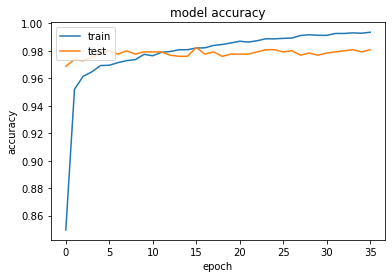

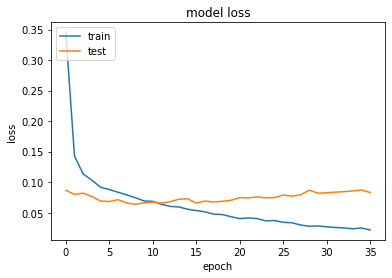

In [22]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# 7. Evaluate on Test Set

In [23]:
y_pred = model.predict(X_test_feature)>0.5
print(classification_report(
    y_test,y_pred,digits=4,target_names=['Cat','Dog']
)
     )

              precision    recall  f1-score   support

         Cat     0.9730    0.9808    0.9769       625
         Dog     0.9806    0.9728    0.9767       624

    accuracy                         0.9768      1249
   macro avg     0.9768    0.9768    0.9768      1249
weighted avg     0.9768    0.9768    0.9768      1249



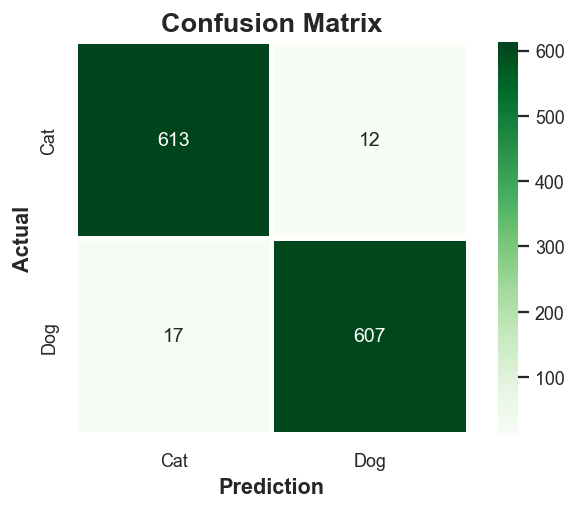

In [24]:
def make_confusion_matrix(y_test,y_predict):  
    
    confusion = confusion_matrix(y_test,y_predict)
    
    sns.set(style='white',font_scale=0.9)
    plt.figure(dpi=130)
    
    ax = sns.heatmap(confusion, 
                     cmap='Greens', 
                     annot=True, 
                     square=True, 
                     fmt='d',
                     linewidth=2,
                     xticklabels=['Cat','Dog'],
                     yticklabels=['Cat','Dog']); 
    
    plt.xlabel('Prediction',weight='bold',fontsize=12)
    plt.ylabel('Actual',weight='bold',fontsize=12)
    plt.title('Confusion Matrix',weight='bold',fontsize=15)
    
make_confusion_matrix(y_test,y_pred)

# 8. Error Analysis - Misclassified Test Examples

In [33]:
df_test = pd.DataFrame()
df_test['image_path'] = test_dataset.filenames
df_test['Actual'] = y_test.astype(int)
df_test['Predict'] = y_pred.astype(int)
df_test['Actual_Animal'] = df_test['Actual'].map({0:'Cat',1:'Dog'})


df_error = df_test[df_test['Actual']!=df_test['Predict']]
df_error['Predicted_Animal'] = df_error['Predict'].map({0:'Cat',1:'Dog'})
df_error['image'] = df_error['image_path'].apply(lambda x:'<img src="./data_by_set/test/{}" /> '.format(x))
df_error['image_path'] = df_error['image_path'].apply(lambda x:'./data_by_set/test/{}'.format(x))
df_error.reset_index(inplace=True)

pd.set_option('display.max_colwidth', -1)
HTML(df_error[['Actual_Animal','Predicted_Animal','image_path','image']].to_html(escape=False))

,Actual_Animal,Predicted_Animal,image_path,image
0,Cat,Dog,./data_by_set/test/Cat\11457.jpg,
1,Cat,Dog,./data_by_set/test/Cat\2904.jpg,
2,Cat,Dog,./data_by_set/test/Cat\3868.jpg,
3,Cat,Dog,./data_by_set/test/Cat\3892.jpg,
4,Cat,Dog,./data_by_set/test/Cat\4190.jpg,
5,Cat,Dog,./data_by_set/test/Cat\6051.jpg,
6,Cat,Dog,./data_by_set/test/Cat\738.jpg,
7,Cat,Dog,./data_by_set/test/Cat\7599.jpg,
8,Cat,Dog,./data_by_set/test/Cat\8076.jpg,
9,Cat,Dog,./data_by_set/test/Cat\8470.jpg,
